# Act 2. Multicolinealidad

> Alfonso Pineda | A01660394  
Mariana Rincón | A01654973  
Karla González | A01541526  
Salvador Mendoza | A01067783  

**Fecha de entrega:** 20 de Octubre de 2023

---

Como primer instancia, importamos las bibliotecas necesarias y cargamos el conjunto de datos Abalone utilizando la biblioteca `ucimlrepo`. Posteriormente, creamos un DataFrame de Pandas para facilitar el manejo de los datos.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
pip install ucimlrepo

A continuación, eliminamos la columna 'Sex' del DataFrame, ya que no es relevante para nuestro análisis y modelado. Además, preparamos los datos de características (`X`) y el objetivo (`Y`) para su futuro uso. También realizamos conversiones de tipo de datos para asegurarnos de que sean numéricos.

Asimismo, imprimimos información sobre el conjunto de datos Abalone, que incluye metadatos y detalles de las variables.

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)
df = pd.DataFrame(abalone.data.features, columns=abalone.data.feature_names)

# Drop the 'Sex' column
df.drop('Sex', axis=1, inplace=True)

# data (as pandas dataframes)
X = abalone.data.features
X = X.loc[:, X.columns != 'Sex']
Y = abalone.data.targets

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)

df['Rings'] = Y.astype(float)

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Life Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscop

In [ ]:
X = X.astype(float)  # Convert X to float data type
Y = Y.astype(float)  # Convert Y to float data type

Finalmente, en esta sección, mostramos las primeras filas del DataFrame y las representaciones de las matrices de características (`X`) y el objetivo (`Y`).

In [ ]:
df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0


In [ ]:
print(X)

      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0      0.455     0.365   0.095        0.5140          0.2245          0.1010   
1      0.350     0.265   0.090        0.2255          0.0995          0.0485   
2      0.530     0.420   0.135        0.6770          0.2565          0.1415   
3      0.440     0.365   0.125        0.5160          0.2155          0.1140   
4      0.330     0.255   0.080        0.2050          0.0895          0.0395   
...      ...       ...     ...           ...             ...             ...   
4172   0.565     0.450   0.165        0.8870          0.3700          0.2390   
4173   0.590     0.440   0.135        0.9660          0.4390          0.2145   
4174   0.600     0.475   0.205        1.1760          0.5255          0.2875   
4175   0.625     0.485   0.150        1.0945          0.5310          0.2610   
4176   0.710     0.555   0.195        1.9485          0.9455          0.3765   

      Shell_weight  
0           0.1500

In [ ]:
print(Y)

      Rings
0      15.0
1       7.0
2       9.0
3      10.0
4       7.0
...     ...
4172   11.0
4173   10.0
4174    9.0
4175   10.0
4176   12.0

[4177 rows x 1 columns]


## Etapa 1: Puntos leverage, influyentes y outliers
En el análisis de modelos de regresión, la evaluación y el manejo de valores atípicos, influyentes y de alta influencia son tareas cruciales. Estos conceptos son fundamentales para comprender cómo los datos atípicos pueden afectar los resultados de un modelo de regresión, y cómo se pueden abordar de manera efectiva.

**Valor de $R^2$ y Parámetros:**

Es una métrica que indica cuánta variabilidad en la variable dependiente (o respuesta) puede ser explicada por el modelo de regresión. Cuanto más cercano a 1 sea el valor de $R^2$, mejor es la capacidad del modelo para ajustarse a los datos. Los parámetros de un modelo de regresión, como las pendientes y las intercepciones, son estimaciones de los efectos de las variables independientes sobre la variable dependiente.

> **Puntos Leverage:**  
Los puntos de leverage son observaciones que tienen un valor atípico en una o más de las variables independientes. Esto significa que son puntos de datos que tienen un impacto inusualmente alto en la estimación de los parámetros del modelo, por lo que pueden afectar significativamente los resultados del modelo.

> **Puntos Influyentes:**  
Observaciones que tienen un impacto inusualmente alto en los resultados del modelo. Pueden ser puntos de datos con valores extremos o puntos con un alto grado de influencia en la estimación de los parámetros del modelo.

> **Outliers:**  
Observaciones que se alejan significativamente del patrón general de los datos. Pueden ser valores extremos en una variable o valores que están lejos de la tendencia general de los datos.



A lo largo de esta etapa, profundizaremos en el análisis de los resultados obtenidos. Examinaremos en detalle cómo los valores de R^2 y los parámetros del modelo evolucionan con las transformaciones y el manejo de outliers.

###Cálculo de $R^2$ y sus parámetros - datos originales

In [ ]:
X_fit = sm.add_constant(X)

model = sm.OLS(Y, X_fit)

model = model.fit()

print(model.params)

const              2.985154
Length            -1.571897
Diameter          13.360916
Height            11.826072
Whole_weight       9.247414
Shucked_weight   -20.213913
Viscera_weight    -9.829675
Shell_weight       8.576242
dtype: float64


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     665.2
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:23:28   Log-Likelihood:                -9250.0
No. Observations:                4177   AIC:                         1.852e+04
Df Residuals:                    4169   BIC:                         1.857e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.9852      0.269     11.

El valor de $R^2$, que es 0.528, sugiere que aproximadamente la mitad de la variabilidad en los anillos se explica por las variables independientes incluidas en el modelo. Esto puede considerarse relativamente bueno, pero es evidente que hay una parte significativa de la variabilidad no explicada.

Al observar los p-valores, podemos ver que algunas variables, como "Length," tienen p-valores elevados, indicando que su contribución al modelo es menos significativa. En contraste, otras variables, como "Whole_weight" y "Shucked_weight," tienen p-valores muy bajos, es decir, son estadísticamente significativas para predecir los anillos.

Al modelo tener un valor F-statistic de 665.2, nos habla que al menos una de las variables independientes tiene un efecto significativo en los anillos.

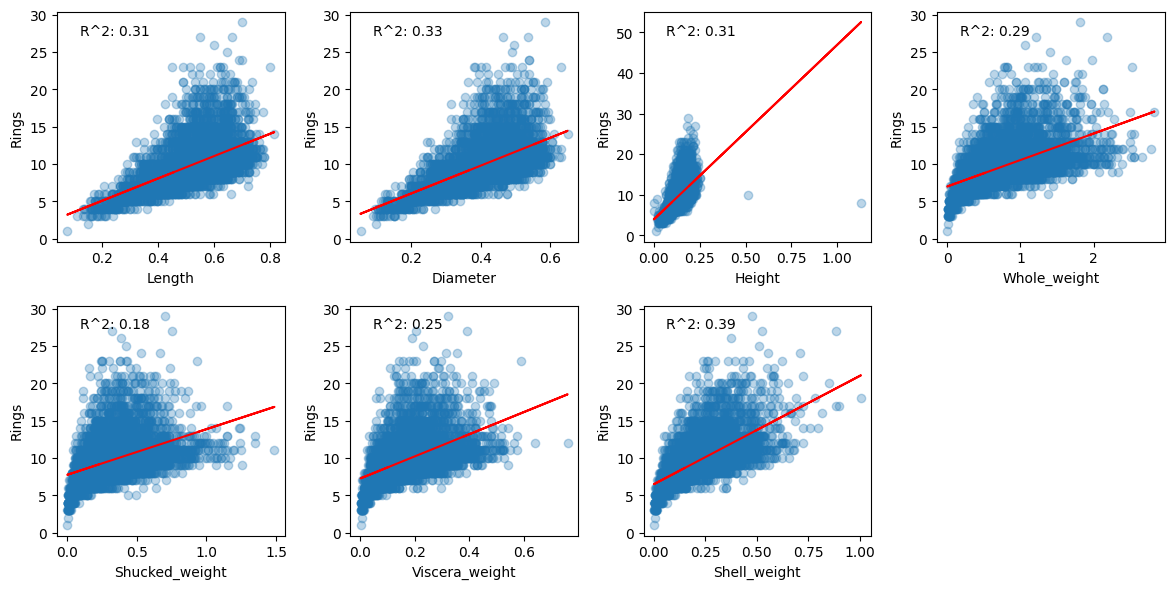

In [ ]:
# Figura con subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Variables en X (sin la columna 'Sex')
x_variables = X.columns

for i, variable in enumerate(x_variables):
    # Fila y columna en la que se encuentra el gráfico actual
    row = i // 4
    col = i % 4

    x_values = X[variable]
    y_values = df['Rings']  # Usar df en lugar de 'y'

    # Ajuste de la línea de regresión
    coefficients = np.polyfit(x_values, y_values, 1)  # 1 indica un modelo lineal

    # Función de regresión lineal usando los coeficientes
    regression_line = np.poly1d(coefficients)

    # Cálculo de los valores predichos para la línea de regresión
    predicted_values = regression_line(x_values)

    # Cálculo de la R-cuadrada
    residuals = y_values - predicted_values
    ss_total = np.sum((y_values - np.mean(y_values))**2)
    ss_residual = np.sum(residuals**2)
    r_squared = 1 - (ss_residual / ss_total)

    # Gráfico de dispersión
    axs[row, col].scatter(x_values, y_values, alpha=0.3)
    axs[row, col].set_xlabel(variable)
    axs[row, col].set_ylabel('Rings')

    # Línea de regresión
    axs[row, col].plot(x_values, predicted_values, color="red")

    # Valor R^2
    axs[row, col].text(0.1, 0.9, f"R^2: {r_squared:.2f}", transform=axs[row, col].transAxes, fontsize=10)

fig.tight_layout()
axs[1, 3].axis('off')
plt.show()

Los resultados de los valores R-cuadrado obtenidos en los gráficos de dispersión de las diferentes variables explicativas muestran que hay una variabilidad en la calidad de ajuste del modelo de regresión lineal. Los valores de R-cuadrado varían de 0.18 a 0.39, indicando que las variables explicativas están contribuyendo en cierta medida a la variabilidad de la variable de respuesta.

A continuación, pasaremos al siguiente paso, que es buscar los puntos de `leverage`, `puntos influyentes` y `outliers`. Utilizaremos técnicas de diagnóstico para identificar y examinar estos puntos para evaluar su efecto en el ajuste y las conclusiones del modelo.

### Puntos leverage, influyentes y outliers

In [ ]:
# Calcula los puntos de leverage
leverage = model.get_influence().hat_matrix_diag

# Calcula los valores influyentes
influence = model.get_influence().resid_studentized_external

# Encuentra los outliers basados en una métrica como el valor absoluto del residuo estandarizado
outliers = np.abs(influence) > 2  # Puedes ajustar el umbral según tus necesidades

# Muestra los resultados
print("Puntos de leverage:")
print(leverage)

print("\nValores influyentes:")
print(influence)

# Identifica los índices de las observaciones perjudiciales y beneficiosas
perjudiciales = np.where(influence > 2)[0]
beneficiosas = np.where(influence < -2)[0]

print("\nObservaciones perjudiciales (valores influyentes positivos):", perjudiciales)
print("\nObservaciones beneficiosas (valores influyentes negativos):", beneficiosas)

# Filtra las observaciones que son outliers
outliers_indices = df.index[outliers]

print("\nÍndices de observaciones de los outliers:")
print(outliers_indices)

# Calcula el número total de outliers
num_outliers = np.sum(outliers)
print("\nNúmero total de outliers:", num_outliers)

Puntos de leverage:
[0.00089205 0.00076875 0.00072514 ... 0.00160134 0.00103437 0.0033281 ]

Valores influyentes:
[ 2.80862318 -0.10715457 -0.83257898 ... -0.84869484  0.1725807
  0.43299889]

Observaciones perjudiciales (valores influyentes positivos): [   0    6    7    9   32   33   36   72   82   90  181  198  232  240
  246  256  275  278  287  290  293  294  310  312  313  314  318  340
  351  357  360  362  363  365  375  407  416  417  426  427  428  430
  431  432  433  437  442  449  469  475  480  481  482  483  497  501
  530  540  542  550  570  571  572  573  582  583  589  592  600  602
  613  614  621  623  624  628  638  642  656  658  664  667  671  672
  673  674  675  678  699  725  729  734  743  744  745  746  756  769
  776  778  811 1216 1419 1528 1754 2101 2108 2138 2160 2176 2180 2201
 2202 2209 2270 2275 2277 2305 2307 2315 2319 2328 2334 2335 2336 2344
 2348 2351 2357 2358 2363 2366 2383 2386 2390 2398 2399 2402 2416 2418
 2420 2436 2459 2463 2467 2471 2476 

En los resultados obtenidos, se observa que existen puntos leverage y valores influyentes en nuestro modelo de regresión, recordemos que los puntos de leverage representan las observaciones que tienen un impacto desproporcionado en los resultados del modelo, mientras que los valores influyentes indican las observaciones que tienen un efecto significativo en las conclusiones del modelo.

Se identificaron 250 outliers en el conjunto de datos, siendo observaciones atípicas que distorcionan la relación entre las variables independentes y la dependiente.

Al buscar los puntos de leverage y los valores influyentes, podemos evaluar el efecto de estas observaciones en el ajuste del modelo y tomar deciones respecto a la transformación para lograr lidiar con los outliers, permitiendo mejorar el ajuste del modelo, el cual es el siguiente paso.

### Estrategias de preprocesamiento de datos para el manejo de outliers

Se emplearon algunas estrategias de preprocesamiento de datos para lidiar con los outliers, que incluyen:

**Escalado Min-Max:** Se aplicó a las características para reducir la influencia de los valores atípicos.

**Winsorizing:** Para reemplazar los valores atípicos con valores más cercanos, mejorando así la robustez del modelo.

**Normalización Z-score:** Para estandarizar las características y mitigar el impacto de los outliers.

In [ ]:
# Calcula Q1, Q3 y el IQR para todo el DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
iqr = Q3 - Q1

print("Q1:\n", Q1)
print("\nQ3:\n", Q3)
print("\nIQR:\n", iqr)

# Encuentra los valores atípicos en todo el DataFrame
outliers_iqr = (df < Q1 - 1.5 * iqr) | (df > Q3 + 1.5 * iqr)

# Total de valores atípicos en todo el DataFrame
outliers_count = outliers_iqr.stack().sum()
print("\nNumber of outlier Samples: ", outliers_count)

Q1:
 Length            0.4500
Diameter          0.3500
Height            0.1150
Whole_weight      0.4415
Shucked_weight    0.1860
Viscera_weight    0.0935
Shell_weight      0.1300
Rings             8.0000
Name: 0.25, dtype: float64

Q3:
 Length             0.615
Diameter           0.480
Height             0.165
Whole_weight       1.153
Shucked_weight     0.502
Viscera_weight     0.253
Shell_weight       0.329
Rings             11.000
Name: 0.75, dtype: float64

IQR:
 Length            0.1650
Diameter          0.1300
Height            0.0500
Whole_weight      0.7115
Shucked_weight    0.3160
Viscera_weight    0.1595
Shell_weight      0.1990
Rings             3.0000
dtype: float64

Number of outlier Samples:  554


Se calculan los cuartiles **Q1** y **Q3** junto con el **rango intercuartílico** (IQR) para cada característica del DataFrame. El IQR nos proporciona una medida de dispersión de los datos, y los valores atípicos se definen como aquellos que caen por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR. En este análisis, encontramos un total de 554 valores atípicos. Cabe recalcar que se calcularon los valores atípicos basados en el rango intercuartílico (IQR) **sin modificar los datos**.

**Winsorizing:**

In [ ]:
# Percentiles p5 y p95 para la winsorización
p5, p95 = np.percentile(df, [5, 95])

# Convierte los percentiles a valores entre 0 y 1
p5 /= 100.0
p95 /= 100.0

# Nuevo DataFrame para almacenar los datos winsorizados
df_winsorized = df.copy()

# Winsorización a cada columna
for column in df_winsorized.columns:
    df_winsorized[column] = stats.mstats.winsorize(df_winsorized[column], limits=(p5, p95))

# Cálculo de los límites después de la winsorización para todo el DataFrame
up_lim_winsorized = df_winsorized.mean() + 3 * df_winsorized.std()
dw_lim_winsorized = df_winsorized.mean() - 3 * df_winsorized.std()

print("Upper limits after winsorization:\n", up_lim_winsorized)
print("Lower limits after winsorization:\n", dw_lim_winsorized)

# Valores atípicos después de la winsorización
outliers_winsorized = ((df_winsorized > up_lim_winsorized) | (df_winsorized < dw_lim_winsorized)).stack().sum()
print("\nNumber of outlier Samples after winsorization: ", outliers_winsorized)

Upper limits after winsorization:
 Length             0.865015
Diameter           0.691779
Height             0.244838
Whole_weight       2.095405
Shucked_weight     0.917681
Viscera_weight     0.461738
Shell_weight       0.593230
Rings             17.285412
dtype: float64
Lower limits after winsorization:
 Length            0.175761
Diameter          0.118891
Height            0.030242
Whole_weight     -0.496209
Shucked_weight   -0.228093
Viscera_weight   -0.114085
Shell_weight     -0.132986
Rings             2.005945
dtype: float64

Number of outlier Samples after winsorization:  61


Se trató con los valores atípicos ajustando los valores extremos a ciertos percentiles (en este caso, el 5% y el 95% de los datos). Esto se realiza para evitar que los valores extremos tengan un impacto excesivo en el análisis. Después de aplicar la winsorización, calculamos los nuevos límites (tanto superiores como inferiores) para identificar cualquier valor atípico potencial.

Como resultado, el número de valores atípicos se ha reducido significativamente a 61 después de la winsorización, en comparación con los 554 valores atípicos identificados en el paso anterior.

**Escalado Min-Max:**

In [ ]:
# Escalado Min-Max
scaler = MinMaxScaler()
df_minmax = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Cálculo de los límites inferiores y superiores por columna en el DataFrame escalado
lower_limits_minmax = df_minmax.min()
upper_limits_minmax = df_minmax.max()

# Valores atípicos después del escalado Min-Max
outliers_minmax = (df_minmax < 0) | (df_minmax > 1)
outliers_count_minmax = outliers_minmax.stack().sum()
print("Number of outlier Samples (Min-Max scaling method): ", outliers_count_minmax)

Number of outlier Samples (Min-Max scaling method):  0


Después de aplicar el escalado Min-Max, calculamos los límites inferiores y superiores por la columna en el DataFrame escalado. Lo importante aquí es que, en contraste con las técnicas anteriores, no hay valores atípicos después del escalado Min-Max. Es decir, los datps se han ajustado para que estén dentro del rango deseado sin valores extremos.

**Normalización Z-score**

In [ ]:
# Normalización Z-score
scaler = StandardScaler()
df_zscore = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Cálculo de límites inferiores y superiores
lower_limits_zscore = df_zscore.min()
upper_limits_zscore = df_zscore.max()

# Número total de valores atípicos después del escalado
outliers_zscore = (df_zscore < -3) | (df_zscore > 3) # Valores que estén a más de 3 desviaciones estándar de la media, se considerará valor atípico.
outliers_count_zscore = outliers_zscore.stack().sum()
print("Number of outlier Samples (Z-score scaling method): ", outliers_count_zscore)

Number of outlier Samples (Z-score scaling method):  200


Se identificaron 200 valores atípicos en el conjunto de datos. Esto debido a su alta distancia con respecto a la media en términos de desviaciones estándar.

###Comparación de modelos

In [ ]:
# Nuevo modelo de regresión aplicando Z-score
X_fit_new_zscore = sm.add_constant(df_zscore)
model_new_zscore = sm.OLS(Y, X_fit_new_zscore)
model_new_zscore = model_new_zscore.fit()
print("R-cuadrado (Z-score):", model_new_zscore.rsquared)

# Nuevo modelo de regresión aplicando winsorización
X_fit_new_winsorized = sm.add_constant(df_winsorized)
model_new_winsorized = sm.OLS(Y, X_fit_new_winsorized)
model_new_winsorized = model_new_winsorized.fit()
print("R-cuadrado (Winsorización):", model_new_winsorized.rsquared)

R-cuadrado (Z-score): 1.0
R-cuadrado (Winsorización): 0.8998869270729831


En el modelo de winsorización, se obtiene 61 outliers, con un r-cuadrado de 0.90.

En cambio, Z-score tiene 200 outliers, mayor cantidad que el caso de winsorizacion, y pese a eso, z-score logra una r-cuadrada de 1.0.


Esta diferencia en R-cuadrado podría deberse al hecho de que la winsorización limita los valores atípicos, lo que puede ayudar al modelo a ajustarse mejor a los datos, mientras que la normalización Z-score no limita esos valores. Sin embargo, una R-cuadrada de 1.0 no es confiable y puede ser un indicativo de sobreajuste del modelo.

###Nuevo valor de $R^2$ y parámetros

In [ ]:
# Nuevo modelo de regresión aplicando winsorización
X_fit_new = sm.add_constant(df_winsorized)
model_new = sm.OLS(Y, X_fit_new)
model_new = model_new.fit()

print("Nuevo Modelo de Regresión OLS:")
print(model_new.summary())

Nuevo Modelo de Regresión OLS:
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     4683.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:24:04   Log-Likelihood:                -6009.7
No. Observations:                4177   AIC:                         1.204e+04
Df Residuals:                    4168   BIC:                         1.209e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const        

## Etapa 2: VIF

Durante esta etapa se analizará el factor de inflación de la varianza (VIF), este es una medida que se utiliza en estadísticas y análisis de regresión para evaluar la multicolinealidad, que es la presencia de alta correlación entre las variables independientes en un modelo de regresión. En esencia, el VIF nos proporciona información sobre cuánto aumenta la varianza de los coeficientes de regresión debido a la multicolinealidad.

Cuando las variables independientes en un modelo de regresión están altamente correlacionadas, puede haber varios efectos negativos, como inestabilidad en los coeficientes de regresión, dificultad en la interpretación de los efectos de las variables y una menor capacidad predictiva del modelo.

Cargamos la base de datos y las librerías necesarias

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# fetch dataset
abalone = fetch_ucirepo(id=1)
df = pd.DataFrame(abalone.data.features, columns=abalone.data.feature_names)

# Drop the 'Sex' column
df.drop('Sex', axis=1, inplace=True)

# data (as pandas dataframes)
X = abalone.data.features
X = X.loc[:, X.columns != 'Sex']
Y = abalone.data.targets

# Escalar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)

df['Rings'] = Y.astype(float)


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Life Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscop

**1.- Busca multicolinealidad en los datos usando VIF**

In [ ]:
def compute_vif(X):
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns

    # Calculating VIF for each feature
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Escalar los datos
scaler = StandardScaler()  # Utiliza StandardScaler en lugar de MinMaxScaler
X_standardized = scaler.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)  # Convierte X_standardized en un DataFrame

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_standardized, Y, test_size=0.2, random_state=42)

# Compute the VIF for all given features using standardized data
vif_data_standardized = compute_vif(X_train)
vif_data_standardized = vif_data_standardized[vif_data_standardized['feature'] != 'intercept'].copy()
print(vif_data_standardized)

          feature         VIF
0          Length   42.461291
1        Diameter   43.252550
2          Height    3.260575
3    Whole_weight  125.234966
4  Shucked_weight   32.175389
5  Viscera_weight   17.895297
6    Shell_weight   23.304634


**2.- Analiza y elimina variables independientes que indiquen que hay multicolinealidad**

Eliminando las variables con el VIF mayor

In [ ]:
# Identificar la variable con el VIF más alto
variable_to_remove = vif_data_standardized[vif_data_standardized['VIF'] == vif_data_standardized['VIF'].max()]['feature'].values[0]

# Eliminar la variable con el VIF más alto de tus datos
X_train_reduced = X_train.drop(columns=[variable_to_remove])

# Volver a calcular los valores VIF con los datos reducidos
vif_data_reduced = compute_vif(X_train_reduced)
vif_data_reduced = vif_data_reduced[vif_data_reduced['feature'] != 'intercept']
print("Valores VIF después de eliminar '{}'".format(variable_to_remove))
print(vif_data_reduced)

Valores VIF después de eliminar 'Whole_weight'
          feature        VIF
0          Length  42.450515
1        Diameter  43.230667
2          Height   3.259181
3  Shucked_weight   9.136485
4  Viscera_weight  10.767270
5    Shell_weight   7.567047


En esta primera ronda de eliminación se elimina la variable 'Whole_weight'

In [ ]:
# Identificar la variable con el VIF más alto
variable_to_remove = vif_data_reduced[vif_data_reduced['VIF'] == vif_data_reduced['VIF'].max()]['feature'].values[0]

# Eliminar la variable con el VIF más alto de los datos reducidos
X_train_reduced = X_train_reduced.drop(columns=[variable_to_remove])

# Volver a calcular los valores VIF con los datos reducidos
vif_data_reduced = compute_vif(X_train_reduced)
vif_data_reduced = vif_data_reduced[vif_data_reduced['feature'] != 'intercept']
print("Valores VIF después de eliminar '{}'".format(variable_to_remove))
print(vif_data_reduced)

Valores VIF después de eliminar 'Diameter'
          feature        VIF
0          Length   7.971231
1          Height   3.221463
2  Shucked_weight   9.136383
3  Viscera_weight  10.764071
4    Shell_weight   7.227416


En la siguiente ronda de eliminación se elimina la variable 'Diameter'

In [ ]:
# Identificar la variable con el VIF más alto
variable_to_remove = vif_data_reduced[vif_data_reduced['VIF'] == vif_data_reduced['VIF'].max()]['feature'].values[0]

# Eliminar la variable 'Viscera_weight' de los datos reducidos
X_train_reduced = X_train_reduced.drop(columns=[variable_to_remove])

# Volver a calcular los valores VIF con los datos reducidos
vif_data_reduced = compute_vif(X_train_reduced)
vif_data_reduced = vif_data_reduced[vif_data_reduced['feature'] != 'intercept']
print("Valores VIF después de eliminar '{}'".format(variable_to_remove))
print(vif_data_reduced)

Valores VIF después de eliminar 'Viscera_weight'
          feature       VIF
0          Length  7.678564
1          Height  3.200700
2  Shucked_weight  6.278130
3    Shell_weight  6.457140


Por último se elimina la variable 'Viscera_weight'

**3.- Calcular el valor de MSE.**

In [ ]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [ ]:
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 5.055541144299382


In [ ]:
from scipy.stats import pearsonr
import numpy as np

# Aplana y convierte los DataFrames en matrices NumPy
Y_test_array = Y_test.to_numpy().flatten()
Y_pred_array = Y_pred.flatten()

# Calcula el coeficiente de correlación
correlation_coefficient, _ = pearsonr(Y_test_array, Y_pred_array)

print("Coeficiente de Correlación:", correlation_coefficient)

Coeficiente de Correlación: 0.730065629814984


**Pregunta 1:** ¿Cómo cambio el valor de $R^2$ del modelo?¿A que se lo adjudica?

Considerando que al principio se tenía un valor de $R^2$ de 0.528, este valor llegó a mejorar hasta un 0.7300 utilizando el método VIF, en el cual se busca la variable que presente una mayor multicolinealidad para esta dejarla fuera del modelo y realizar este proceso hasta que las variables restantes resulten en un valor VIF menor a 10. De esta forma se logra mejorar la estabilidad del modelo, ademas que al reducir la multicolinealidad, el coeficiente de determinación ($R^2$) del modelo tiende a mejorar.

**Pregunta 2:** ¿Como cambiaron los coeficientes?¿Qué interpretación se puede obtener con los nuevos valores de coeficientes?

Conforme se hacían las rondas de eliminación de coeficientes por identificar el valor VIF mayor los valores VIF de las demás variables restantes mejoraban al realizar el proceso nievamente, esto se podría explicar debido a que se reduce la multicolinealidad inicial calculada, es decir, cuando se decide eliminar una variable con un alto valor de VIF del modelo, se está eliminando una fuente significativa de multicolinealidad. Esta variable estaba altamente correlacionada con otras variables, lo que inflaba los VIF de todas las variables involucradas.

## Etapa 3: Componentes principales, $R^2$ y MSE

En el contexto de análisis de datos, dos conceptos fundamentales que desempeñan un papel crucial son los Componentes Principales (PCA) y el Error Cuadrático Medio (MSE).


El **PCA** siendo una técnica que ayuda a reducir la dimensionalidad que se utiliza para simplificar conjuntos de datos multivariados al transformarlos en un conjunto de variables llamadas componentes principales, los cuales se eligen de manera que capturen la mayor varianza en los datos.
Esto teniendo como consecuencia el aumento de la interpretabilidad de los datos, la eliminación de la colinealidad y la reducción de la complejidad del modelo.


Por otro lado, el **MSE**, se va a usar para cuantificar cuán bien un modelo se ajusta a los datos y realiza predicciones. La comparación del MSE entre diferentes modelos puede ayudarnos a determinar cuál de ellos tiene un mejor rendimiento en términos de ajuste y capacidad predictiva.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
Y_pcr = df['Rings']
X_pcr = df.drop(['Rings'], axis = 1)
print(X.head())

   Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  
0         0.150  
1         0.070  
2         0.210  
3         0.155  
4         0.055  


###Componentes principales

In [ ]:
np.set_printoptions(suppress=True,precision=3)

pca = PCA()

X_reduced = pca.fit_transform(scale(X_pcr))

print('Vector de la varianza explicada por cada dimensión')
print(pca.explained_variance_)

print('\nVarianza explicada únicamente por la i+primera dimensión')
print(pca.explained_variance_ratio_)

print('\nVarianza explicada por las dimensiones acumuladas')
print(pca.explained_variance_.cumsum())

Vector de la varianza explicada por cada dimensión
[6.357 0.279 0.167 0.114 0.065 0.013 0.007]

Varianza explicada únicamente por la i+primera dimensión
[0.908 0.04  0.024 0.016 0.009 0.002 0.001]

Varianza explicada por las dimensiones acumuladas
[6.357 6.636 6.804 6.918 6.982 6.995 7.002]


El PCA ha creado 7 dimensiones, y el primer componente principal explica la mayoría de los datos de la varianza en los datos. Los siguientes componentes explican cantidades decrecientes de varianza. El segundo conjunto de resultados muestra la varianza explicada por cada dimensión en relación con la varianza total, donde se observa que el primer componente captura la mayor parte de la información. El tercer conjunto de resultados muestra la varianza explicada acumulativa a medida que se agregan más dimensiones.

([<matplotlib.axis.XTick at 0x7fac9a221c90>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

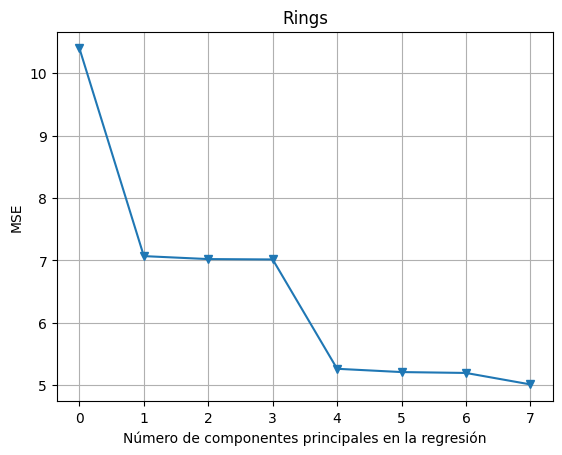

In [ ]:
# Muestras, componentes principales
n, pc = X_reduced.shape

# n-fold CV, con shuffle
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
model_pcr = LinearRegression()
mse = []

# Cálculo del MSE con el intercepto (sin componentes principales ni regresión)
score = -1 * model_selection.cross_val_score(model_pcr, np.ones((n,1)), Y_pcr.ravel(),
                                             cv=kf,
                                             scoring='neg_mean_squared_error').mean()
mse.append(score)

# Cálculo de MSE usando CV para los componentes principales, añadiendo un componente a la vez
for i in np.arange(1, pc+1):
  score = -1 * model_selection.cross_val_score(model_pcr, X_reduced[:,:i], Y_pcr.ravel(),
                                               cv=kf,
                                               scoring='neg_mean_squared_error').mean()
  mse.append(score)

x_axis = np.arange(0, len(mse))

# Gráfica de resultados
plt.plot(x_axis, mse, '-v')
plt.xlabel('Número de componentes principales en la regresión')
plt.ylabel('MSE')
plt.title('Rings')
plt.grid()
plt.xticks(x_axis)

In [ ]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 90.79,  94.78,  97.17,  98.8 ,  99.72,  99.9 , 100.  ])

Se observa un porcentaje acumulado de varianza explicada por los componentes principales en orden descendente. Esto significa que el primer componente principal explica aproximadamente el 90.79% de la varianza total en los datos. A medida que avanzamos a través de los componentes principales, la varianza explicada acumulada aumenta. El segundo componente principal agrega aproximadamente un 3.99% adicional, el tercero alrededor de un 2.39% más, y así sucesivamente.

([<matplotlib.axis.XTick at 0x7fac9ac346a0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11')])

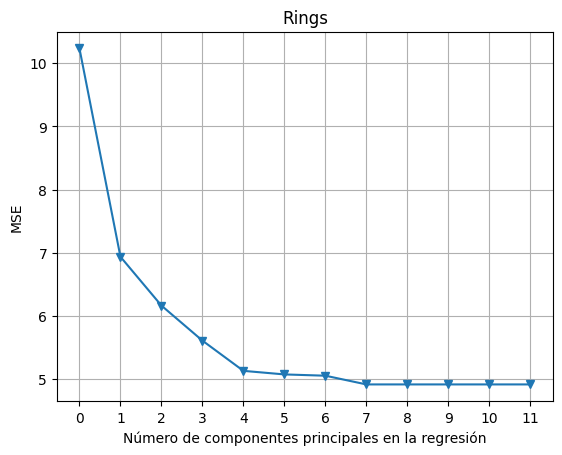

In [ ]:
pca2 = PCA()

# Split de entrenamiento y prueba
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_pcr, Y_pcr,
                                                                    test_size=0.5,
                                                                    random_state=1)
# Datos escalados
X_reduced_train = pca2.fit_transform(scale(X_train))
n2, pc2 = X_reduced_train.shape

# n-fold CV, con shuffle
kf2 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
model_pcr2 = LinearRegression()
mse2 = []

# Cálculo del MSE con el intercepto (sin componentes principales ni regresión)
score2 = -1 * model_selection.cross_val_score(model_pcr2, np.ones((n2,1)), y_train.ravel(),
                                             cv=kf2,
                                             scoring='neg_mean_squared_error').mean()
mse2.append(score2)

# Cálculo de MSE usando CV para los componentes principales, añadiendo un componente a la vez
for i in np.arange(1, 12):
  score2 = -1 * model_selection.cross_val_score(model_pcr2, X_reduced_train[:,:i], y_train.ravel(),
                                               cv=kf2,
                                               scoring='neg_mean_squared_error').mean()
  mse2.append(score2)

x_axis2 = np.arange(0, len(mse2))

# Gráfica de resultados
plt.plot(x_axis2, mse2, '-v')
plt.xlabel('Número de componentes principales en la regresión')
plt.ylabel('MSE')
plt.title('Rings')
plt.grid()
plt.xticks(x_axis2)

En este caso, vemos que el MSE disminuye a medida que se añaden más componentes principales a la regresión.

In [ ]:
X_reduced_test = pca2.transform(scale(X_test))[:,:5]

modelpcr = sm.OLS(y_train, sm.add_constant(X_reduced_train[:,:5]))
fitted_modelpcr = modelpcr.fit()

# Predicción con el dataset de prueba
pred = fitted_modelpcr.predict(sm.add_constant(X_reduced_test))
msepcr = mean_squared_error(y_test, pred)

print('Mean squared error: {}'.format(np.round(msepcr,2)))

Mean squared error: 5.29


In [ ]:
# Nuevo modelo de regresión aplicando pcr
print("Nuevo Modelo de Regresión OLS con PCR:")
print(fitted_modelpcr.summary())

Nuevo Modelo de Regresión OLS con PCR:
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     429.0
Date:                Sat, 21 Oct 2023   Prob (F-statistic):          6.63e-317
Time:                        00:51:43   Log-Likelihood:                -4650.9
No. Observations:                2088   AIC:                             9314.
Df Residuals:                    2082   BIC:                             9348.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

En conclusión, un valor de "Mean squared error" (MSE) de 5.29 significa que, en promedio, las predicciones hechas por el modelo de regresión (PCR) con las cinco componentes principales en el conjunto de prueba tienen un error cuadrático medio de 5.29 unidades al cuadrado en relación a los valores reales.

En cuanto al R-cuadrada del nuevo modelo utilizando PCR, podemos ver que no mejora, y sigue teniendo un valor de 0.5, lo cual nos indica que la variable de respuesta está siendo explicada únicamente por poco más del 50% de las variables predictoras. Por lo cual nosotros conlcuímos que para este caso específico y este dataset, el ánalisis de componentes principales y su regresión no es el método más óptimo para manejar los datos y la variable predicha `Rings`.

¿Mejoro el valor de $R^2$ y MSE del modelo PCR respecto al metodo de VIF?¿A que se lo adjudica?
No, el modelo obtenido a través del método VIF obtuvo mejores resultados tanto en la $R^2$ como en el MSE.

* PCR:
  - $R^2$ = 0.507
  - MSE = 5.29

* VIF:
  - $R^2$ = 0.730
  - MSE = 5.05

En cuanto a qué se le adjudica la diferencia de resultados, se nos ocurren las siguientes opciones relacionadas a la selección de características y la multicolinealidad de los datos:

* El método VIF podría haber seleccionado un conjunto de características más relevante para el modelo en comparación con el enfoque PCR. Al seleccionar características más importantes y omitir las menos relevantes, es probable que el modelo VIF tenga un mejor ajuste a los datos.

* El método VIF puede ayudar a reducir la multicolinealidad en los datos al seleccionar características menos correlacionadas. La multicolinealidad puede dificultar la interpretación y la estabilidad de los coeficientes en un modelo de regresión, por lo que su reducción podría mejorar el rendimiento del modelo.


El Error Cuadrático Medio (MSE) es una métrica de evaluación comúnmente utilizada en problemas de regresión para medir la capacidad de predicción de un modelo. Se calcula al comparar las predicciones del modelo con los valores reales en un conjunto de datos de prueba, que generalmente se deriva al dividir el conjunto de datos original en dos: uno para entrenar el modelo y otro para evaluar su rendimiento. Un MSE más bajo indica un mejor ajuste del modelo a los datos y una mayor precisión en las predicciones.

En este caso, los valores de MSE más bajos para el método de VIF (MSE = 5.05) en comparación con el método PCR (MSE = 5.29) sugieren que el modelo basado en VIF tiene una capacidad de predicción ligeramente mejor en el conjunto de prueba, lo que implica un menor error promedio en las predicciones para ese método.


A continuación, se presentan las ventajas y desventajas de ambos enfoques.

Ventajas del modelo VIF:
* Mayor $R^2$ y menor MSE: En este caso específico, el modelo VIF mostró un $R^2$ más alto y un MSE más bajo en comparación con el modelo PCR. Esto indica se ajusta mejor a los datos y hace predicciones más precisas.

* Selección de características más relevante: El método VIF selecciona un conjunto de características más relevante para el modelo al eliminar características altamente correlacionadas.

* Reducción de multicolinealidad: Al reducir la multicolinealidad en los datos, el modelo VIF puede ofrecer coeficientes de regresión más estables y fácilmente interpretables.

Desventajas del modelo VIF:
* Eliminación de características: El modelo elimina características del conjunto de datos, lo que puede resultar en la pérdida de información.
* Sensible a la selección de características iniciales: El rendimiento del modelo VIF puede depender de las características iniciales seleccionadas. Si las características iniciales no son representativas, el modelo VIF puede no dar buenos resultados.

Ventajas del modelo PCR:
* Utilización de componentes principales: Utiliza componentes principales, lo que puede ser útil en casos donde las características originales están altamente correlacionadas.
* Menos susceptible a overfitting: PCR reduce la dimensionalidad de los datos, lo que puede ayudar a prevenir el overfitting.

Desventajas del modelo PCR:
* Menor $R^2$ y mayor MSE: En este caso específico, el modelo PCR mostró un $R^2$ más bajo (0.507) y un MSE más alto (5.29) en comparación con el modelo VIF, lo que indica un ajuste menos preciso a los datos.
* Menos efectivo en la reducción de multicolinealidad: PCR no aborda directamente la multicolinealidad en los datos y puede no ser tan efectivo como el método VIF en ese sentido.

Por lo tanto, podemos concluir que el modelo VIF es más conveniente usarlo cuando se desee seleccionar un conjunto de características más relevante, reducir la multicolinealidad y obtener un mejor rendimiento en términos de ajuste y predicción.

Mientras que el uso de PCR es para cuando se desee reducir la dimensionalidad de los datos y prevenir el overfitting, y cuando la interpretabilidad de los componentes principales sea importante.